# FbProphet model implementation
- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

# about dataSet
- the data contains the stock information of Microsoft from 04/01/2015 to 04/01/2021
- Open : Opening price
- High : Highest value of the day
- Low : Lowest value of the day
- Close : Closing price
- Volume : Number of shares traded on that day

In [1]:
# importing recquired packages
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('H:\\Data Science Repository\\Projects\\microsoft stock time series fbprophet\\Microsoft_Stock.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
# printing basic information about the dataset
print(df.info())
print("------------------------------")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB
None
------------------------------
              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962

<AxesSubplot: xlabel='Date'>

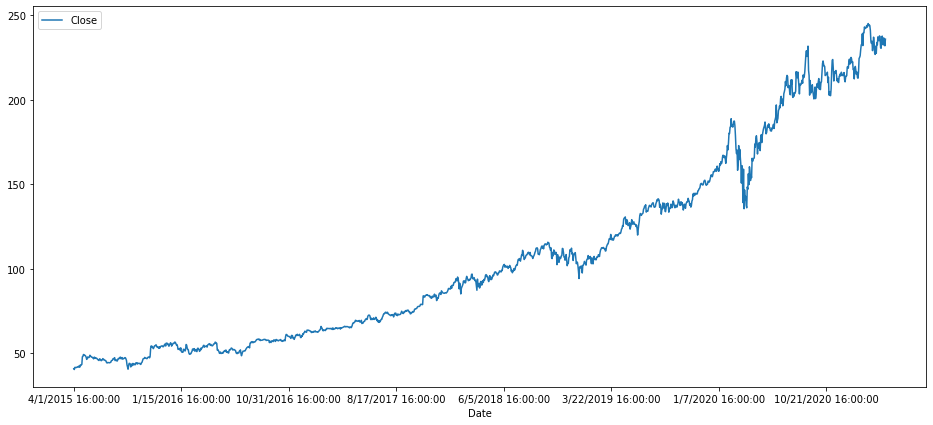

In [5]:
# plotting the graph
df.plot(x='Date',y='Close',figsize=(16,7))

# BoxCox Transformation
- The Box-Cox transformation transforms our data so that it closely resembles a normal distribution. In many statistical techniques, we assume that the errors are normally distributed. This assumption allows us to construct confidence intervals and conduct hypothesis tests. By transforming your target variable, we can (hopefully) normalize our errors (if they are not already normal). Additionally, transforming our variables can improve the predictive power of our models because transformations can cut away white noise.

In [6]:
from statsmodels.base.transform import BoxCox
bc=BoxCox()

In [7]:
df['Close']

0        40.72
1        40.29
2        41.55
3        41.53
4        41.42
         ...  
1506    232.34
1507    236.48
1508    235.24
1509    231.85
1510    235.77
Name: Close, Length: 1511, dtype: float64

In [8]:
df['Close'], lmbda=bc.transform_boxcox(df['Close'])

In [9]:
df['Close']

0       2.580415
1       2.575514
2       2.589700
3       2.589479
4       2.588261
          ...   
1506    3.253639
1507    3.259290
1508    3.257610
1509    3.252962
1510    3.258329
Name: Close, Length: 1511, dtype: float64

In [10]:
# We need to change our column names as given below as that is how FbProphet recognizes the variables.
data = df[["Date","Close"]]
data.columns=["ds","y"]

In [11]:
model_params={
    "daily_seasonality":False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "seasonality_mode": "multiplicative",
    "growth": "logistic"
}

In [12]:
model=Prophet(**model_params)

data["cap"]=data['y'].max() + data['y'].std()*0.05

model.add_seasonality(name="monthly",period=30,fourier_order=10)
model.add_seasonality(name="quaterly",period=92.95,fourier_order=10)
model.add_country_holidays("US")

model.fit(data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [13]:
future=model.make_future_dataframe(periods=365)
future["cap"]=data["cap"].max()
forecast=model.predict(future)

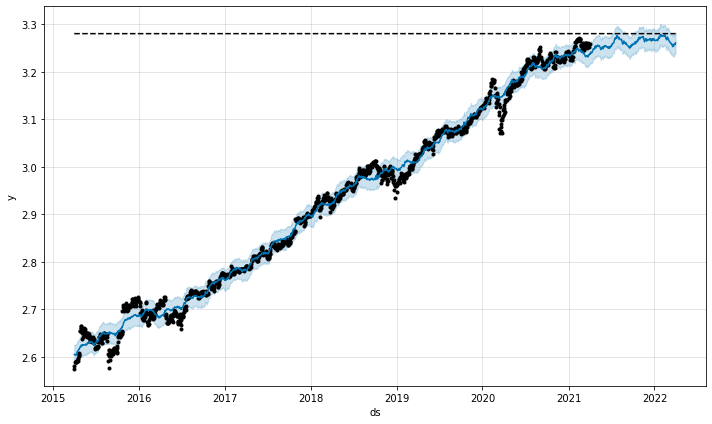

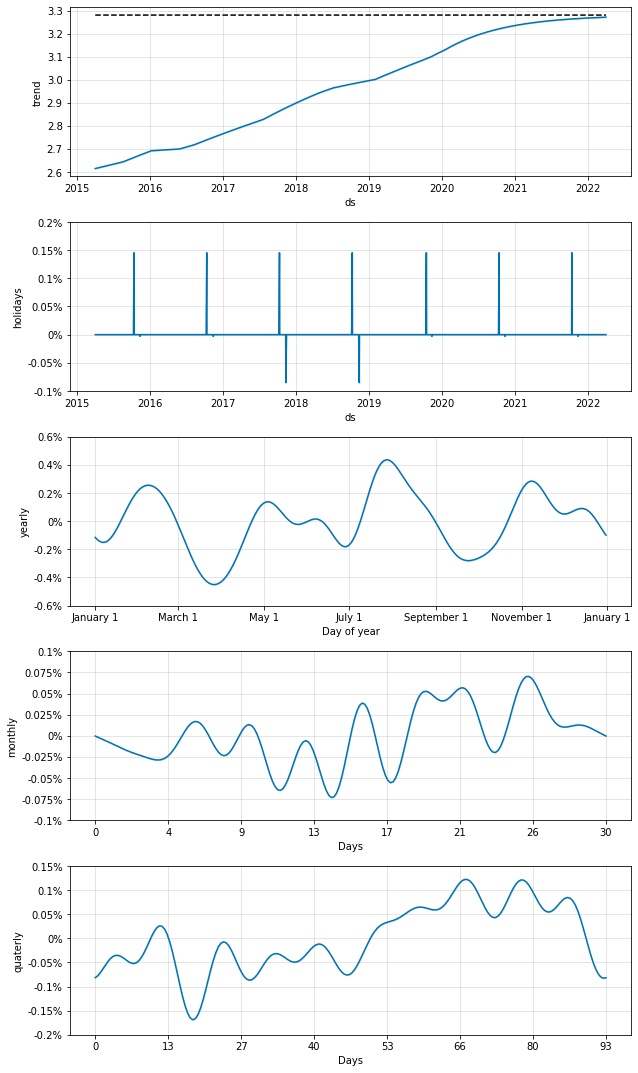

In [14]:
model.plot(forecast);
model.plot_components(forecast);

# Cross Validation

In [15]:
import itertools
from prophet.diagnostics import cross_validation,performance_metrics

In [16]:
param_grid={
    "daily_seasonality":[False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [True],
    "growth": ["logistic"],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]

}

all_params=[
            dict(zip(param_grid.keys(),v))
            for v in itertools.product(*param_grid.values())
]

In [17]:
rmses=list()

for params in all_params:
    m = Prophet(**params)
    m = m.add_seasonality(name="monthly",period=30,fourier_order=5)
    m = m.add_seasonality(name="quaterly",period=92.25,fourier_order=10)
    m.add_country_holidays(country_name="US")
    m.fit(data)
    df_cv = cross_validation(m,initial="730 days",period="365 days", horizon="365 days",parallel="processes")
    df_p = performance_metrics(df_cv,rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

    best_params = all_params[np.argmin(rmses)]

print("\nThe best params are:",best_params)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002928001BD00>
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000292806F3F10>
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000292FC419820>
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 4 forecasts with cutoffs between 2017-04-01 16:00:00 and 2020-03-31 16:00:00
INFO:prophet:Applying in 


The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


In [18]:
# train with the best parameters
best_model=Prophet(**best_params)
best_model=best_model.add_seasonality(name="monthly",period=30,fourier_order=5)
best_model=best_model.add_seasonality(name="quaterl",period=92.25,fourier_order=10)
best_model.add_country_holidays(country_name="US")
best_model.fit(data)
future=best_model.make_future_dataframe(periods=365,freq='D')
future["cap"]=data["cap"].max()
forecast=best_model.predict(future)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


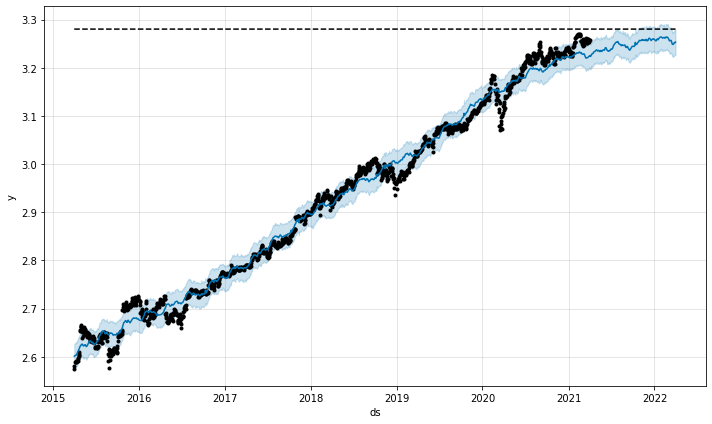

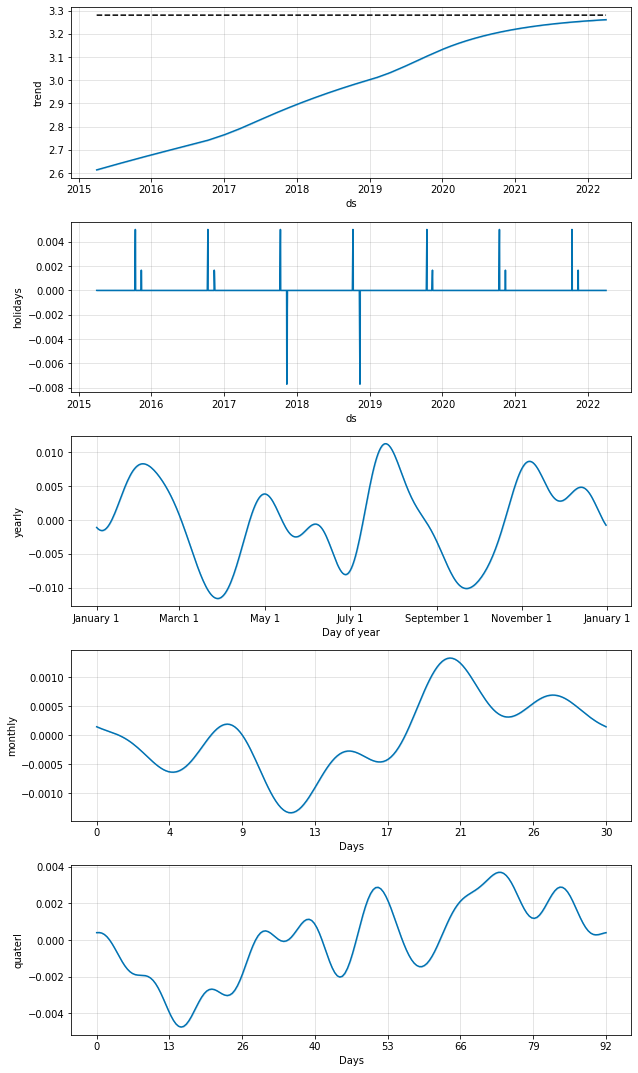

In [19]:
best_model.plot(forecast);
best_model.plot_components(forecast);

In [20]:
# We can look at the info and columns of forecast and we can see all the holidays listed in it
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 74 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   ds                                                     1876 non-null   datetime64[ns]
 1   trend                                                  1876 non-null   float64       
 2   cap                                                    1876 non-null   float64       
 3   yhat_lower                                             1876 non-null   float64       
 4   yhat_upper                                             1876 non-null   float64       
 5   trend_lower                                            1876 non-null   float64       
 6   trend_upper                                            1876 non-null   float64       
 7   Christmas Day                                          1876 non-null 

<AxesSubplot: xlabel='ds'>

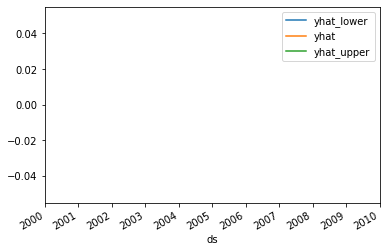

In [26]:
forecast['yhat']=bc.untransform_boxcox(x=forecast['yhat'],lmbda=lmbda)
forecast['yhat_lower']=bc.untransform_boxcox(x=forecast['yhat_lower'],lmbda=lmbda)
forecast['yhat_upper']=bc.untransform_boxcox(x=forecast['yhat_upper'],lmbda=lmbda)
forecast.plot(x='ds',y=['yhat_lower','yhat','yhat_upper'])

# Another way of implementing Prophet model

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [24]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
raw_df = pd.read_csv('H:\\Data Science Repository\\Projects\\microsoft stock time series fbprophet\\Microsoft_Stock.csv')

In [26]:
raw_df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [27]:
raw_df['Date']= pd.to_datetime(raw_df['Date'])

In [28]:
# We need to change our column names as given below as that is how FbProphet recognizes the variables.
data = raw_df[["Date","Close"]]
data.columns=["ds","y"]

<AxesSubplot: xlabel='ds'>

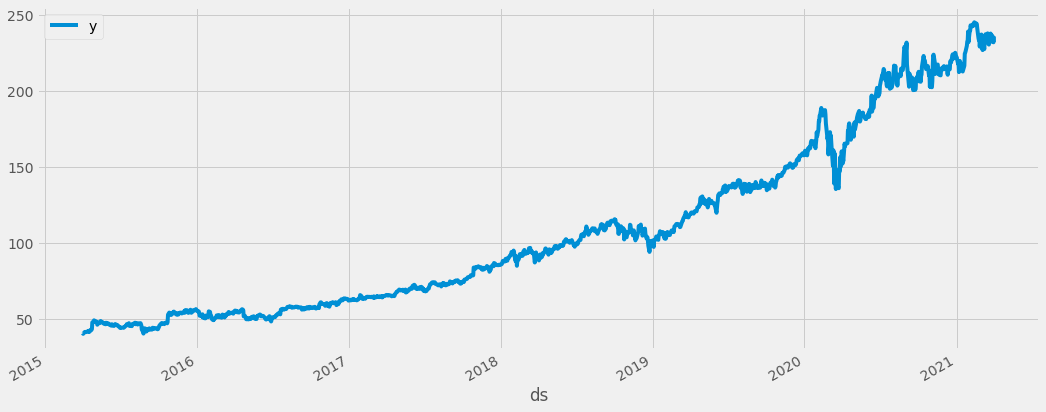

In [29]:
# plotting the graph
data.plot(x='ds',y='y',figsize=(16,7))

# Train / Test Split

In [30]:
# split the data into 75% train and 25% test
train = data.loc[:1133]
test = data.loc[1134:]

In [31]:
train

,ds,y
0,2015-04-01 16:00:00,40.72
1,2015-04-02 16:00:00,40.29
2,2015-04-06 16:00:00,41.55
3,2015-04-07 16:00:00,41.53
4,2015-04-08 16:00:00,41.42
...,...,...
1129,2019-09-25 16:00:00,139.36
1130,2019-09-26 16:00:00,139.54
1131,2019-09-27 16:00:00,137.73
1132,2019-09-30 16:00:00,139.03


In [32]:
test

,ds,y
1134,2019-10-02 16:00:00,134.65
1135,2019-10-03 16:00:00,136.28
1136,2019-10-04 16:00:00,138.12
1137,2019-10-07 16:00:00,137.12
1138,2019-10-08 16:00:00,135.67
...,...,...
1506,2021-03-25 16:00:00,232.34
1507,2021-03-26 16:00:00,236.48
1508,2021-03-29 16:00:00,235.24
1509,2021-03-30 16:00:00,231.85


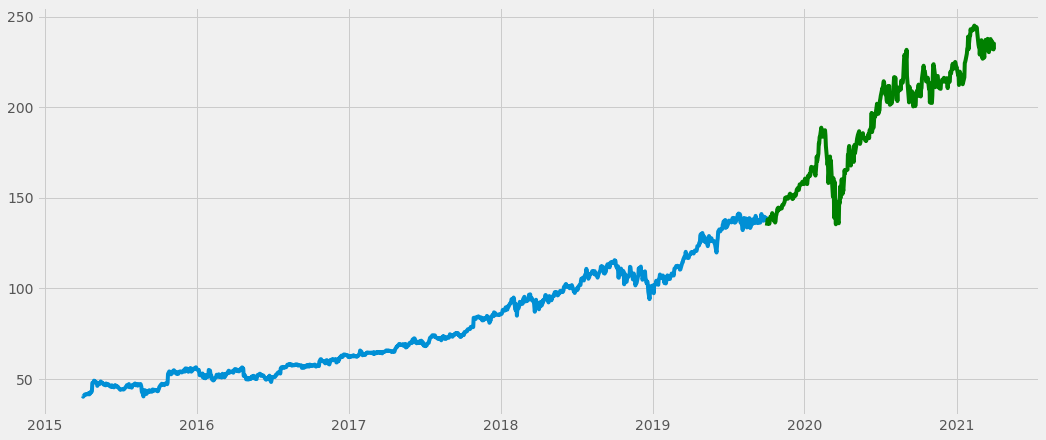

In [33]:
plt.figure(figsize=(16,7));
plt.plot(train.ds, train.y);
plt.plot(test.ds, test.y, color='green');

# Model Train

In [34]:
model = Prophet()
model_fit = model.fit(train)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


# Model predict

In [35]:
train_predictions = model_fit.predict()

In [36]:
pred = model.predict(test)

In [37]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-10-02 16:00:00,126.463819,137.576776,143.102445,126.463819,126.463819,13.794963,13.794963,13.794963,-9.875929,...,22.101160,22.101160,22.101160,1.569732,1.569732,1.569732,0.0,0.0,0.0,140.258782
1,2019-10-03 16:00:00,126.564514,137.575602,143.160066,126.564514,126.564514,13.714004,13.714004,13.714004,-9.875929,...,22.114777,22.114777,22.114777,1.475156,1.475156,1.475156,0.0,0.0,0.0,140.278518
2,2019-10-04 16:00:00,126.665209,137.610286,143.121487,126.665209,126.665209,13.686420,13.686420,13.686420,-9.875929,...,22.183649,22.183649,22.183649,1.378700,1.378700,1.378700,0.0,0.0,0.0,140.351629
3,2019-10-07 16:00:00,126.967294,137.537616,142.910926,126.967294,126.967294,13.237561,13.237561,13.237561,-9.875929,...,22.017358,22.017358,22.017358,1.096132,1.096132,1.096132,0.0,0.0,0.0,140.204855
4,2019-10-08 16:00:00,127.067989,137.650951,143.287901,127.067989,127.067989,13.244656,13.244656,13.244656,-9.875929,...,22.109912,22.109912,22.109912,1.010674,1.010674,1.010674,0.0,0.0,0.0,140.312645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2021-03-25 16:00:00,180.839150,105.813215,281.846479,95.416531,271.129007,9.637608,9.637608,9.637608,-9.875929,...,22.114777,22.114777,22.114777,-2.601240,-2.601240,-2.601240,0.0,0.0,0.0,190.476758
373,2021-03-26 16:00:00,180.939845,105.592718,281.803393,95.024021,271.688390,9.730924,9.730924,9.730924,-9.875929,...,22.183649,22.183649,22.183649,-2.576796,-2.576796,-2.576796,0.0,0.0,0.0,190.670769
374,2021-03-29 16:00:00,181.241930,105.097986,281.995434,94.835362,272.752732,9.656595,9.656595,9.656595,-9.875929,...,22.017358,22.017358,22.017358,-2.484835,-2.484835,-2.484835,0.0,0.0,0.0,190.898525
375,2021-03-30 16:00:00,181.342625,104.589972,282.278418,94.515888,273.125115,9.787603,9.787603,9.787603,-9.875929,...,22.109912,22.109912,22.109912,-2.446379,-2.446379,-2.446379,0.0,0.0,0.0,191.130228


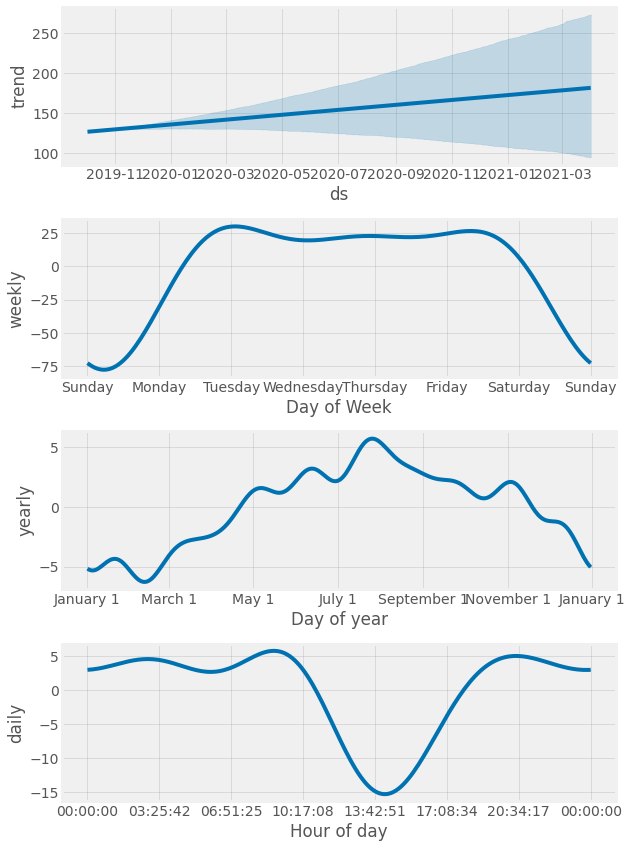

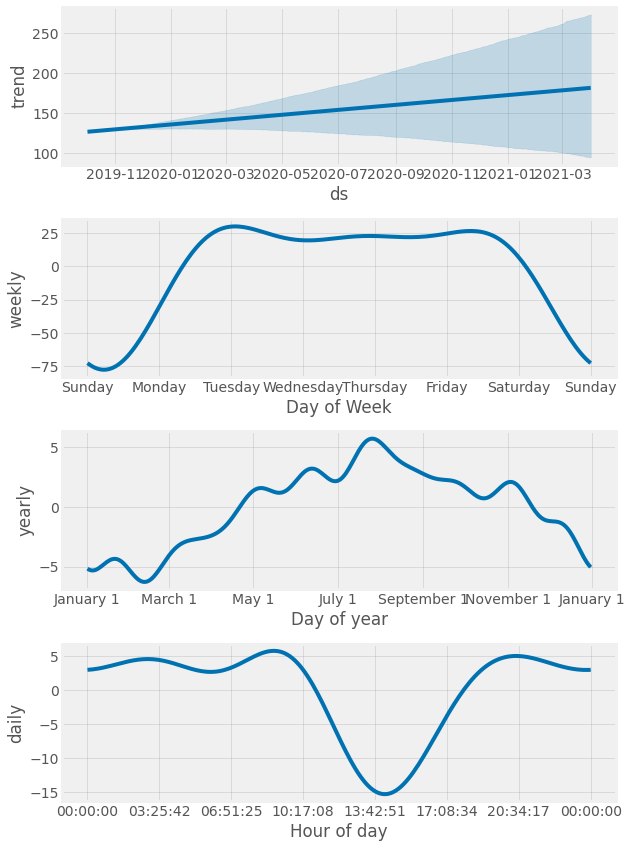

In [38]:
model.plot_components(pred)

In [39]:
train_predictions = train_predictions['yhat']
pred = pred['yhat']

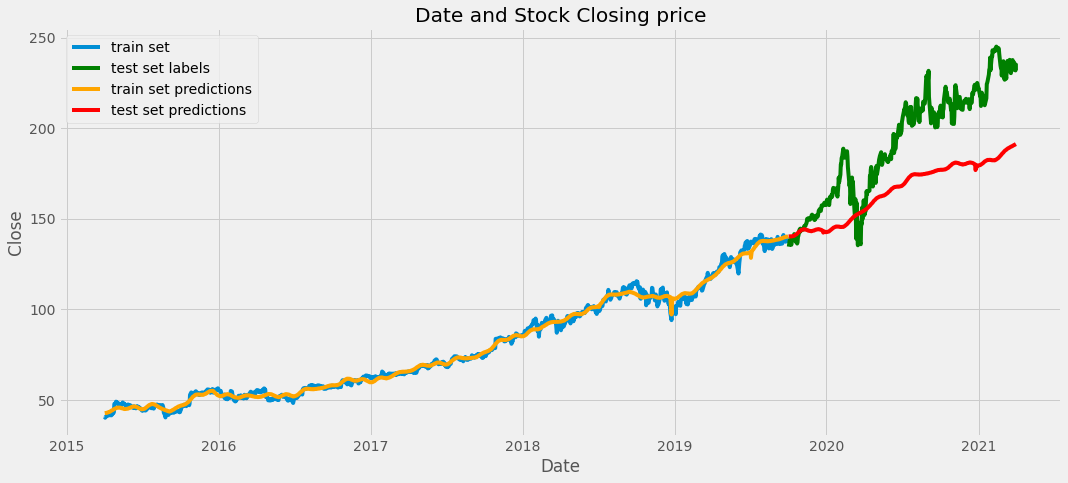

In [61]:
plt.figure(figsize=(16,7));
plt.plot(train.ds, train.y);
plt.plot(test.ds, test.y, color='green');
plt.plot(train.ds, train_predictions, color='orange');
plt.plot(test.ds, pred, color='red');

plt.xlabel('Date');
plt.ylabel('Close');
plt.title('Date and Stock Closing price');
plt.legend(['train set', 'test set labels', 'train set predictions', 'test set predictions']);

# Evaluate the model with Error Metrics

In [41]:
np.sqrt(mean_squared_error(y_true=test['y'],
                   y_pred=pred))

31.257442121095828

In [42]:
mean_absolute_error(y_true=test['y'],
                   y_pred=pred)

27.060425869299824

In [43]:
mean_absolute_percentage_error(y_true=test['y'],
                   y_pred=pred)

13.179722428321918

# Adding Holidays
- Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

- We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [44]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=raw_df.index.min(),
                        end=raw_df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [45]:
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [46]:
# Predict on training set with model
pred_with_holidays = model_with_holidays.predict(df=test)

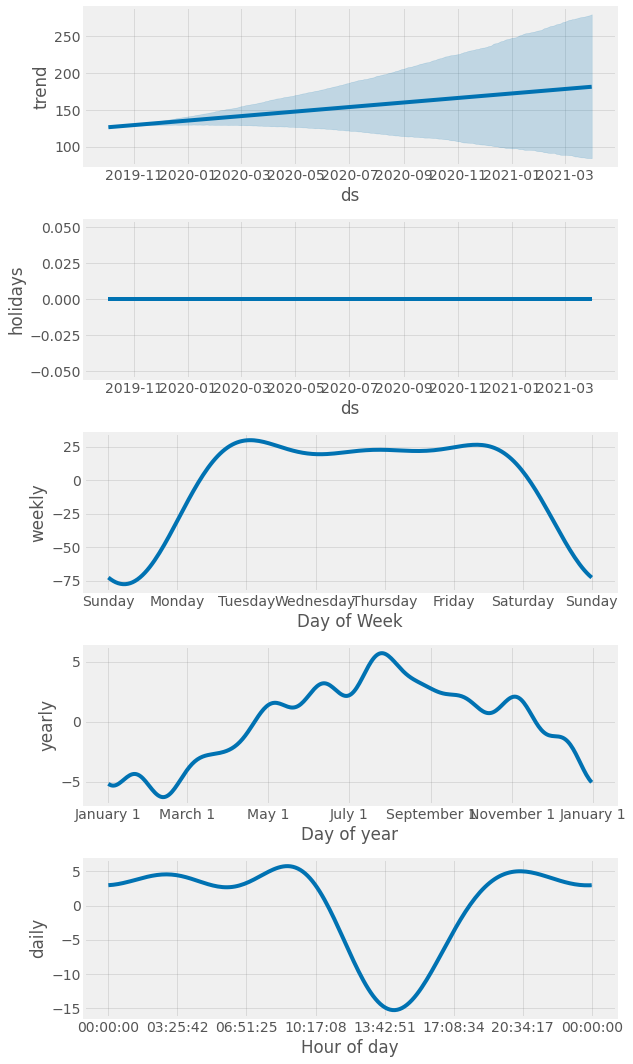

In [47]:
fig = model_with_holidays.plot_components(pred_with_holidays)
plt.show()

In [49]:
np.sqrt(mean_squared_error(y_true=test['y'],
                   y_pred=pred_with_holidays['yhat']))

31.257442121095828

In [56]:
mean_absolute_error(y_true=test['y'],
                   y_pred=pred_with_holidays['yhat'])

27.060425869299824

In [57]:
mean_absolute_percentage_error(y_true=test['y'],
                   y_pred=pred_with_holidays['yhat'])

13.179722428321918

# Predict into the Future

In [62]:
future=model.make_future_dataframe(periods=365)
forecast=model.predict(future)

In [63]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)

In [64]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-04-01 16:00:00,42.847132
1,2015-04-02 16:00:00,42.885100
2,2015-04-06 16:00:00,42.949277
3,2015-04-07 16:00:00,43.100516
4,2015-04-08 16:00:00,43.158508


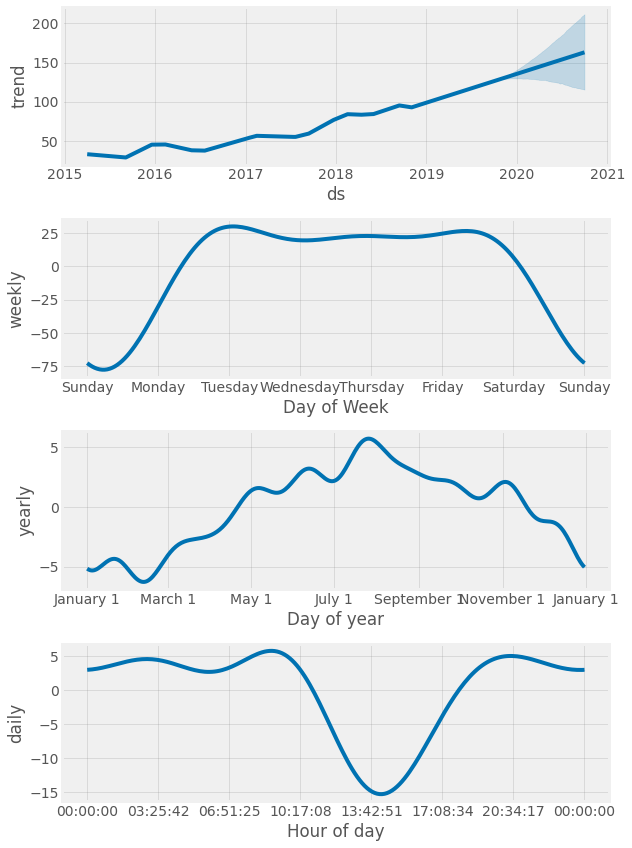

In [65]:
model.plot_components(forecast);

# Using ARIMA 

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [36]:
data_df = pd.read_csv('H:\\Data Science Repository\\Projects\\microsoft stock time series fbprophet\\Microsoft_Stock.csv')

In [37]:
data_df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [38]:
data_df = data_df.set_index('Date')
data_df.index = pd.to_datetime(data_df.index)
data_df = data_df[['Close']]

In [39]:
data_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


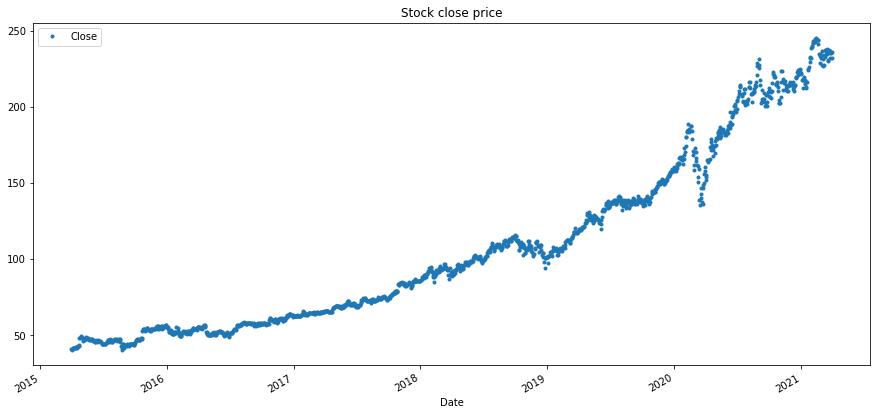

In [42]:
data_df.plot(style='.',
        figsize=(15, 7),
        title='Stock close price')
plt.show()

# Train / Test Split

In [46]:
train_df = data_df.loc[data_df.index < '2020-01-01']
test_df = data_df.loc[data_df.index >= '2020-01-01']

In [47]:
train_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2019-12-24 13:00:00,157.38
2019-12-26 16:00:00,158.67
2019-12-27 16:00:00,158.96


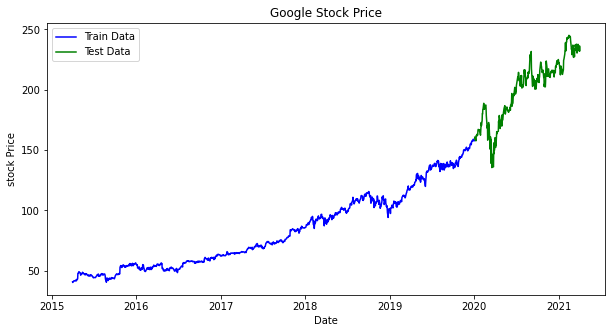

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.index, train_df.Close, label="Train Data", color='blue')
plt.plot(test_df.index, test_df.Close, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('stock Price')
plt.title('Google Stock Price')
plt.legend()
plt.show()

# Perform stationarity check
- make time series stationary if necessary, by differencing, decomposing or other method. Get the value of d

In [51]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

timeseries = train_df['Close']
check_stationarity(timeseries)

Results of Dickey-Fuller Test:
Test Statistic                    1.763253
p-value                           0.998273
#Lags Used                        8.000000
Number of Observations Used    1188.000000
Critical Value (1%)              -3.435866
Critical Value (5%)              -2.863976
Critical Value (10%)             -2.568067
dtype: float64


- The Dickey-Fuller test returns a test statistic and a p-value. The null hypothesis of the test is that the time series is non-stationary. If the p-value is less than the significance level (typically 0.05), then we can reject the null hypothesis and conclude that the time series is stationary. Since p-value is more than 0.05, difference the time series to make it stationary.

In [54]:
# Perform the 2 time difference to test which one to take
train_df['Close_diff'] = train_df.Close.diff()
train_df['Close_diff_diff'] = train_df.Close.diff().diff()

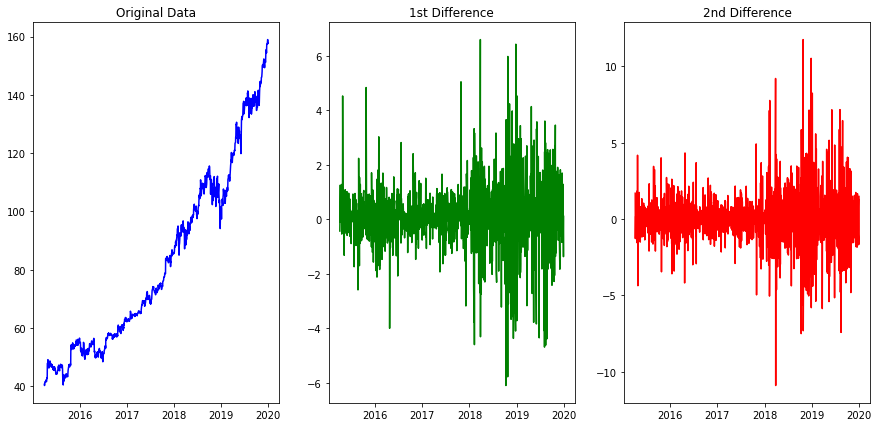

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
ax1.plot(train_df.index, train_df.Close, color='blue')
ax1.set_title('Original Data')
ax2.plot(train_df.index, train_df.Close_diff, color='green')
ax2.set_title('1st Difference')
ax3.plot(train_df.index, train_df.Close_diff_diff, color='red')
ax3.set_title('2nd Difference')
plt.show()

- from the above plot, we can say that neither original data nor 1st and 2nd Difference is stationary because mean and variance is not stationary over time. So ARIMA model may not perform well on this dataset. Let's check mean and variance of the original, 1st Difference, and 2nd Difference data

In [56]:
train_df_copy = train_df.copy()
train_df_copy.index.name = 'Date'
train_df_copy.reset_index(inplace=True)
train_df_copy['Date'] = pd.to_datetime(train_df_copy['Date'])
train_df_copy.groupby(train_df_copy.Date.dt.year).agg(['mean', 'std', 'var'])

Close                        Close_diff                      \
            mean        std         var       mean       std       var   
Date                                                                     
2015   47.729476   4.368241   19.081527   0.077684  0.821008  0.674055   
2016   55.259325   3.834578   14.703992   0.026429  0.771655  0.595452   
2017   71.984024   7.001347   49.018854   0.093227  0.694694  0.482600   
2018  101.033984   7.917807   62.691664   0.063865  1.779049  3.165017   
2019  130.383571  14.902712  222.090828   0.222738  1.575568  2.482415   

     Close_diff_diff                      
                mean       std       var  
Date                                      
2015       -0.002116  1.122671  1.260389  
2016        0.000278  1.130871  1.278869  
2017        0.002311  1.027488  1.055732  
2018        0.005418  2.712305  7.356596  
2019       -0.004246  2.349713  5.521153

- It looks like the 1st Difference has performed a better job of converting original data to stationary data because mean and variance do not vary too much over the year when compared with 2nd Difference. Let's validate this argument using Dickey-Fuller test

In [57]:
check_stationarity(train_df['Close_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.470747e+01
p-value                        2.882292e-27
#Lags Used                     7.000000e+00
Number of Observations Used    1.188000e+03
Critical Value (1%)           -3.435866e+00
Critical Value (5%)           -2.863976e+00
Critical Value (10%)          -2.568067e+00
dtype: float64


- Only One time differencing lowers the p-value to less than 0.05. So we can estimate to use d=1 for our model will be a good value

#  plot_acf() and plot_pacf() functions
- from statsmodels to check for autocorrelation in the data. This will also help to choose the right parameters (p, q) for the model.

In [58]:
def plot_pacf_acf(col):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))
    plot_acf(train_df[col].dropna(), lags=40, ax=ax1)
    plot_pacf(train_df[col].dropna(), lags=40, ax=ax2)
    plt.show()

Let's plot the ACF and PACF for the original data

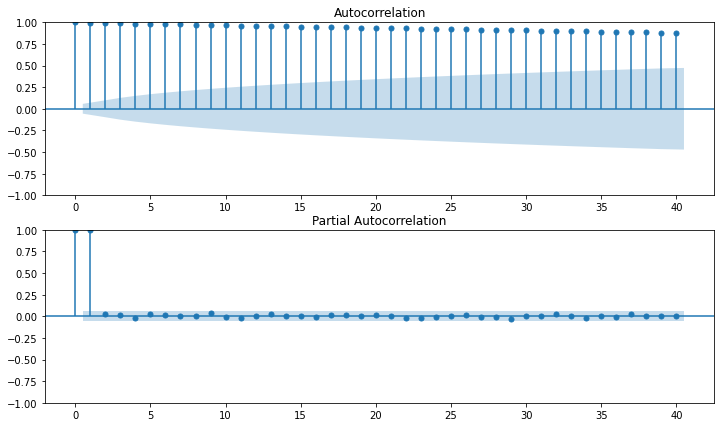

In [59]:
plot_pacf_acf('Close')

In the Autocorrelation graph, we can see that original data is highly correlated with low lag data but not that much correlated with high lags. Partial Autocorrelation graph shows that original data is only highly correlated with only 1st lag.

Lets plot the ACF and PACF for stationary data (1st Difference) to determine the value of (p, q)

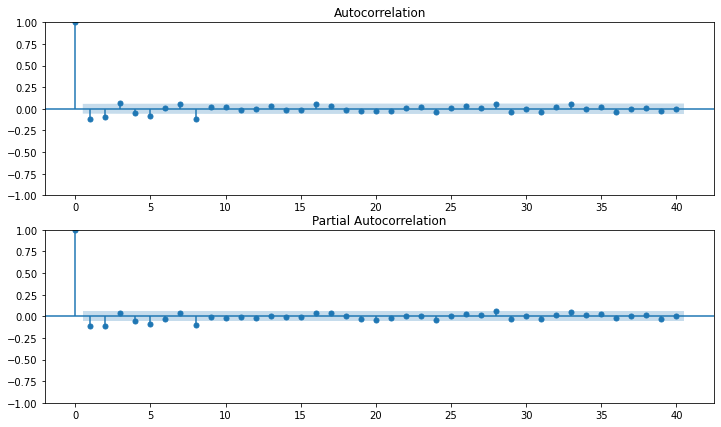

In [60]:
plot_pacf_acf('Close_diff')

So, looking at the PACF plot above, we can estimate to use 1 AR terms (p=1) for our model, since only lag 1 is out of the confidence interval, and lag 2 is in the blue area. Also from ACF plot, , we can estimate to use 1 MA terms (q=1) for our model, since only lag 1 is out of the confidence interval, and lag 2 is in the blue area.

So for our model, we can estimate (p, d, q) = (1,1,1). This could be a good starting estimate of the parameters. Lets run the model and get prediction

In [115]:
a = train_df.copy()
a.reset_index(inplace=True)

def run_model(model_params):
    model = ARIMA(a.Close, order = model_params)
    model_fit = model.fit()
    print(model_fit.summary())
    predictions = model_fit.predict(start=a.index[0], end=a.index[-1] + test_df.shape[0]).to_frame()
    predictions['Date'] = train_df.index.values.tolist() + test_df.index.values.tolist()
    rmse = sqrt(mean_squared_error(test_df.Close, predictions.predicted_mean[a.index[-1] + 1:]))
    print("RSME:", rmse)
    
run_model((1,1,1))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1197
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1939.522
Date:                Mon, 17 Apr 2023   AIC                           3885.043
Time:                        12:22:48   BIC                           3900.303
Sample:                             0   HQIC                          3890.792
                               - 1197                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5300      0.106      5.005      0.000       0.322       0.738
ma.L1         -0.6482      0.096     -6.752      0.000      -0.836      -0.460
sigma2         1.5000      0.035     42.424      0.0

In [82]:
p_params = [1, 2]
d_params = [1,2,3,4]
q_params = [1,2,3]
best_rmse = 1000
best_params = None
result_val = []

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(a.Close, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=a.index[0], end=a.index[-1] + test_df.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test_df.Close, predictions.predicted_mean[a.index[-1] + 1:]))
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

The best parameter using grid search is (2,3,2). Let's run and see the results

In [116]:
run_model((2, 3, 2))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1197
Model:                 ARIMA(2, 3, 2)   Log Likelihood               -1941.321
Date:                Mon, 17 Apr 2023   AIC                           3892.642
Time:                        12:22:54   BIC                           3918.067
Sample:                             0   HQIC                          3902.222
                               - 1197                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1207      0.020     -5.955      0.000      -0.160      -0.081
ar.L2         -0.1066      0.020     -5.240      0.000      -0.146      -0.067
ma.L1         -1.9972      0.006   -320.385      0.0